In [1]:
from matplotlib.ticker import MaxNLocator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import os
import glob
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
region = "Ticino"

In [5]:
csv_target = "./csv/" + region + ".csv"
classnames = ['Bad', 'Good']

In [6]:
# take target values ultil the last useful date (cutting off 2020-2022)
from datetime import datetime

#START_DATE = datetime.strptime('2010-09-11', '%Y-%m-%d')
START_DATE = datetime.strptime('2001-01-05', '%Y-%m-%d')
END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})
target['date'] = pd.to_datetime(target['date'],format = '%Y-%m-%d')

# remove dates not available in features
target = target[target['date'] <= END_DATE]
target = target[target['date'] >= START_DATE]
target_df = target['mean'].to_frame()
target_df.reset_index(inplace = True, drop = True)

In [7]:
# divide target into train/val/test sets from 2001

scaler_t = StandardScaler()

TRAIN_END_DATE = datetime.strptime('2009-12-31', '%Y-%m-%d')
VALID_END_DATE = datetime.strptime('2014-12-31', '%Y-%m-%d')
TEST_END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')

train_perc=0.475 # training data from 2001-01 to 2009-12 included, 411 samples
valid_perc = 0.2625 # 228 samples for valid and test sets
tot_rows = len(target_df)

target_train = target[target['date'] <= TRAIN_END_DATE]['mean'].to_frame()
# fit the scalers on training data
scaler_t.fit(target_train)
# scale all the dataset
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

target_train = target_df.iloc[0:round(tot_rows*train_perc)-1,:]
target_validation = target_df.iloc[round(tot_rows*train_perc)-1:round(tot_rows*(valid_perc+train_perc))]
target_test = target_df.iloc[round(tot_rows*(valid_perc+train_perc)):round(tot_rows*(valid_perc*2+train_perc))]

In [ ]:
# divide target into train/val/test sets from 2009

scaler_t = StandardScaler()

train_perc = 0.6
valid_perc = 0.2

#TRAIN_END_DATE = datetime.strptime('2009-12-31', '%Y-%m-%d')
#VALID_END_DATE = datetime.strptime('2014-12-31', '%Y-%m-%d')
#TEST_END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')

#target_train = target[target['date'] <= TRAIN_END_DATE]['mean'].to_frame()
target_train = target_df.iloc[:round(len(target_df)*train_perc), :]

# fit the scalers on training data
scaler_t.fit(target_train)
# scale all the dataset
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

#target_train = target_df[target['date'] <= TRAIN_END_DATE]
#target_validation = target_df[(target['date'] > TRAIN_END_DATE) & (target['date'] <= VALID_END_DATE)]
#target_test = target_df[target['date'] > VALID_END_DATE]

target_train = target_df.iloc[:round(len(target_df)*train_perc), :]
target_validation = target_df.iloc[round(len(target_df)*train_perc):round(len(target_df)*(train_perc + valid_perc)), :]
target_test = target_df.iloc[round(len(target_df)*(train_perc + valid_perc)):, :]

### Compute and plot quantiles

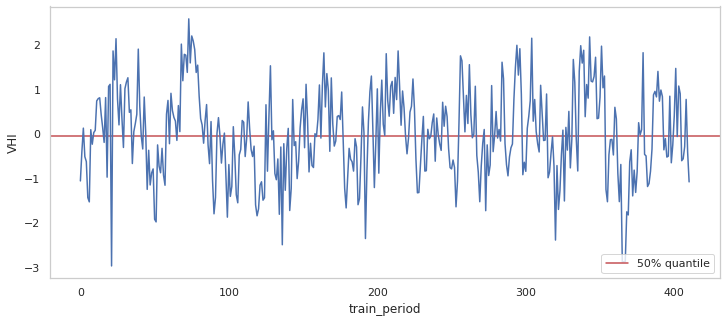

In [8]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})

y_div = target_train['mean'].quantile(0.5)

plt.ylabel("VHI")
plt.xlabel("train_period")

plt.axhline(y_div, label='50% quantile', color = 'r')
plt.legend(loc="lower right")
plt.plot(target_train['mean'])

In [9]:
# transform the target in 2 classes: 0 for bad, 1 for good

target_train['mean'] = target_train['mean'].apply(lambda x: 1 if x > y_div else 0)
target_validation['mean'] = target_validation['mean'].apply(lambda x: 1 if x > y_div else 0)
target_test['mean'] = target_test['mean'].apply(lambda x: 1 if x > y_div else 0)

In [10]:
# see the number of instances for each class for test purpose and to check balance of class

np.unique(target_train['mean'], return_counts = True)

(array([0, 1]), array([206, 205]))

In [11]:
y_train = target_train.values
y_validation = target_validation.values
y_test = target_test.values
y_train_validation = pd.concat([target_train, target_validation]).values

In [12]:
def plot_conmat(true, pred, title, ax):
    conmat = confusion_matrix(true, pred, labels = [0, 1])
    val = np.mat(conmat)

    df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
        )
    
    group_counts = ["Count: {0:0.0f}".format(value) for value in
                df_cm.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    plt.rcParams["figure.figsize"] = (5,5)
    if title is not None : ax.set_title(title) 

In [13]:
def feed_forward():
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(len(classnames), activation='softmax',name='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## CMI features - separate stations

In [ ]:
features_file = "snow_" + region + "_with_aggreg_KNN_12m.csv"
features_df_snow = pd.read_csv(features_file)
features_df_snow.drop(columns=['Unnamed: 0'], inplace = True)
features_df_snow ['Date'] = pd.to_datetime(features_df_snow['Date'], format="%Y-%m-%d")
START_DATE = datetime.strptime('2001-01-05', '%Y-%m-%d')
features_df_snow = features_df_snow[features_df_snow['Date'] >= START_DATE]
features_df_snow.reset_index(inplace = True, drop = True)

csv_with_aggreg = "./features_with_aggregations.csv"
noSnow_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})
noSnow_features ['date'] = pd.to_datetime(noSnow_features['date'], format="%Y-%m-%d")
TEST_END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
noSnow_features = noSnow_features[noSnow_features['date'] <= TEST_END_DATE]
noSnow_features = noSnow_features[noSnow_features.filter(like=region).columns]

features_df = pd.concat([features_df_snow, noSnow_features], axis = 1)

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

TRAIN_END_DATE = datetime.strptime('2009-12-31', '%Y-%m-%d')
VALID_END_DATE = datetime.strptime('2014-12-31', '%Y-%m-%d')

features_df['Date'] = pd.to_datetime(features_df['Date'],format = '%Y-%m-%d')
features_train = features_df[features_df['Date'] <= TRAIN_END_DATE].iloc[:, 1:]
scaler_f.fit(features_train)

features_df_scaled = features_df
features_df_scaled[features_df_scaled.iloc[:, 1:].columns] = scaler_f.transform(features_df.iloc[:, 1:])

features_train = features_df_scaled[features_df_scaled['Date'] <= TRAIN_END_DATE].iloc[:, 1:]
features_validation = features_df_scaled[(features_df_scaled['Date'] > TRAIN_END_DATE) & 
                                  (features_df_scaled['Date'] <= VALID_END_DATE)].iloc[:, 1:]
features_test = features_df_scaled[features_df_scaled['Date'] > VALID_END_DATE].iloc[:, 1:]

features_train_validation = pd.concat([features_train, features_validation])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: ALBANO VERCELLESE
1: BARCENISIO
2: BOCCHETTA DELLE PISSE
3: CAPANNE MARCAROLO
4: CLOT DELLA SOMA
5: COLLE LOMBARDA
6: FEISOGLIO
7: L.SERRU'
8: LAGO AGNEL
9: LAGO CAMPOSECCO
10: LAGO VANNINO
11: MACUGNAGA PECETTO
12: PIEDICAVALLO
13: PRERICHARD
14: RIFUGIO GASTALDI
15: RIFUGIO VACCARONE
16: SALBERTRAND
17: SAUZE CESANA
18: SESTRIERE
19: ALBANO VERCELLESE_1m
20: ALBANO VERCELLESE_4m
21: ALBANO VERCELLESE_6m
22: ALBANO VERCELLESE_12m
23: BARCENISIO_1m
24: BARCENISIO_4m
25: BARCENISIO_6m
26: BARCENISIO_12m
27: BOCCHETTA DELLE PISSE_1m
28: BOCCHETTA DELLE PISSE_4m
29: BOCCHETTA DELLE PISSE_6m
30: BOCCHETTA DELLE PISSE_12m
31: CAPANNE MARCAROLO_1m
32: CAPANNE MARCAROLO_4m
33: CAPANNE MARCAROLO_6m
34: CAPANNE MARCAROLO_12m
35: CLOT DELLA SOMA_1m
36: CLOT DELLA SOMA_4m
37: CLOT DELLA SOMA_6m
38: CLOT DELLA SOMA_12m
39: COLLE LOMBARDA_1m
40: COLLE LOMBARDA_4m
41: COLLE LOMBARDA_6m
42: COLLE LOMBARDA_12m
43: FEISOGLIO_1m
44: FEISOGLIO_4m
45: FEISOGLIO_6m
46: FEISOGLIO_12m
47: L.SERRU'_1m
48: 

In [ ]:
X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
output = { "X" : X_train, "Y" : target_train.values}

with open("./pickles/" + region + ".pickle", "wb") as f:
    pickle.dump(output, f)

In [ ]:
%run "./scripts/main.py" --classification 0 --filename "./pickles/Piemonte_Nord.pickle" --backward 'f' --k 48

### Logistic Regression

In [ ]:
# Piemonte Nord chosen features k = 50(?) (better) [0, 95, 11, 3, 31, 13, 16]  k=5 [58, 8, 6, 63, 31, 19]    
# Piemonte Sud chosen features k = 22 (better) [69, 96, 10, 62, 81, 11, 26, 2, 16]  K=5 [10, 40, 97, 17]

chosen_features_ids = [0, 95, 11, 3, 31, 13, 16]

X_train = features_train.iloc[:,chosen_features_ids].values
X_validation = features_validation.iloc[:,chosen_features_ids].values
X_test = features_test.iloc[:,chosen_features_ids].values

X_train_validation = pd.concat([features_train.iloc[:,chosen_features_ids], features_validation.iloc[:,chosen_features_ids]]).values

In [ ]:
chosen_features_ids = [0, 95, 11, 3, 31, 13, 16]
chosen_features = features_train.iloc[:,chosen_features_ids]
idx_dic = {}
print("Chosen features with CMI feature selection for " + region + " :\n")
for col in chosen_features.columns:
    idx_dic[col] = chosen_features.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

Chosen features with CMI feature selection for Piemonte_Nord :

0: ALBANO VERCELLESE_1m
1: ALBANO VERCELLESE
2: cyclostationary_mean_Piemonte_Nord_tg
3: CAPANNE MARCAROLO
4: PIEDICAVALLO
5: SALBERTRAND


In [ ]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train, y_train.ravel())

print("Train accuracy logistic regression: ", round(log_regr.score(X_train, y_train),3))
print("Valid accuracy logistic regression: ", round(log_regr.score(X_validation, y_validation),3))

Train accuracy logistic regression:  0.676
Valid accuracy logistic regression:  0.636


In [ ]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))

Train accuracy logistic regression:  0.684
Test accuracy logistic regression:  0.654


<ipython-input-76-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


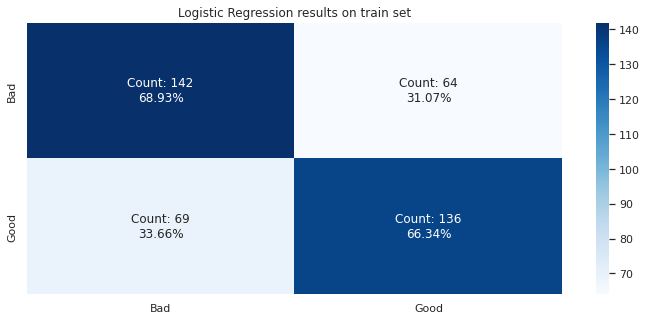

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_train, log_regr.predict(X_train), 'Logistic Regression results on train set', ax=ax)

<ipython-input-663-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


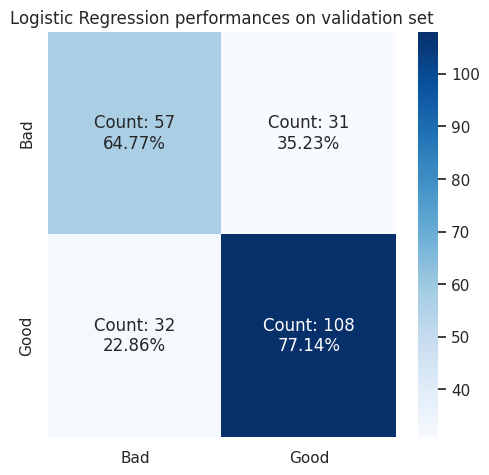

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_validation, log_regr.predict(X_validation), 'Logistic Regression performances on validation set', ax=ax)

<ipython-input-663-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


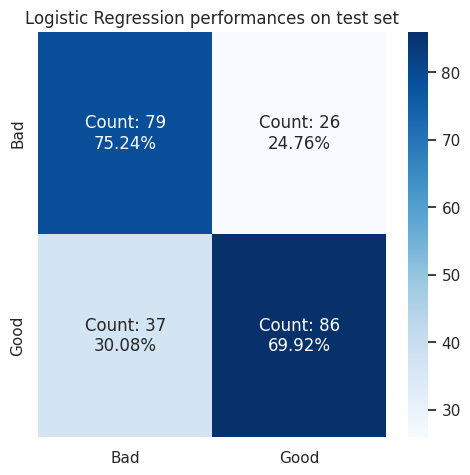

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_test, log_regr.predict(X_test), 'Logistic Regression performances on test set', ax=ax)

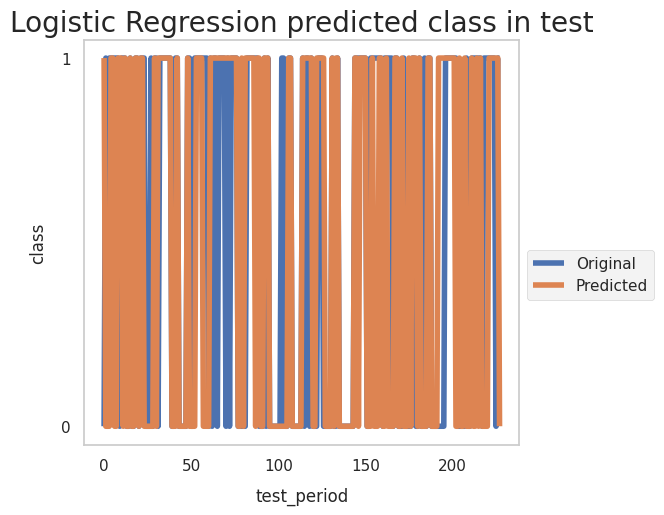

In [ ]:
fig, ax= plt.subplots()
plt.style.use('fivethirtyeight')
#y_test.reset_index(inplace = True, drop = True)
plt.plot(y_test, label='Original')
plt.title('Logistic Regression predicted class in test')
plt.plot(log_regr.predict(X_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Extra Trees Classifier

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 220, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10, 25, 50, 100]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

In [ ]:
from sklearn.model_selection import GridSearchCV

ext = ExtraTreesClassifier(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 3)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_validation, y_train_validation.ravel())

In [ ]:
opt.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 100,
 'n_estimators': 35}

In [ ]:
rfc= ExtraTreesClassifier(random_state=42, max_features = 'auto', min_samples_split = 100, n_estimators = 35, bootstrap = 'True')
rfc.fit(X_train_validation, y_train_validation.ravel())

ExtraTreesClassifier(bootstrap='True', min_samples_split=100, n_estimators=35,
                     random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rfc.predict(X_test))
rf_mse = mean_squared_error(y_test, rfc.predict(X_test))
r2_test = rfc.score(X_test, y_test)
r2_train = rfc.score(X_train_validation, y_train_validation)

print(" ExtraTreesClassifier: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","acc_test: ",round(r2_test,3), "\n", "acc_train: ", round(r2_train,3))

 ExtraTreesClassifier: 
 MAE:  0.237 
 MSE:  0.237 
 acc_test:  0.763 
 acc_train:  0.731


In [ ]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(features_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cyclostationary_mean_tg_4 Importance: 0.3
Variable: cyclostationary_mean_rr_4w_3 Importance: 0.21
Variable: cyclostationary_mean_rr_12w_1 Importance: 0.18
Variable: cyclostationary_mean_tg_1w_4 Importance: 0.16
Variable: cyclostationary_mean_rr_8w_0 Importance: 0.14


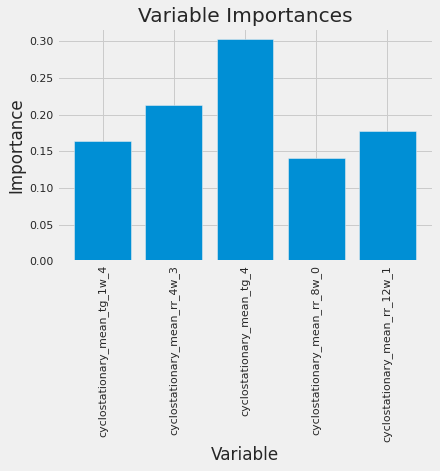

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<ipython-input-27-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


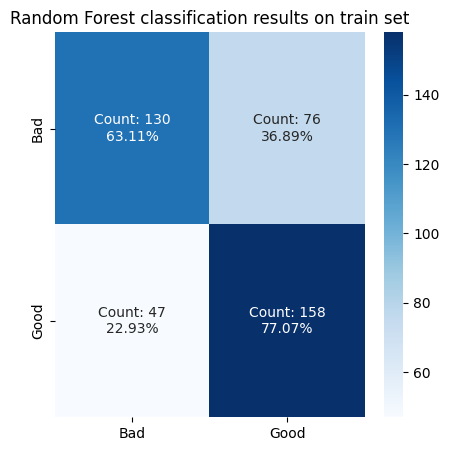

In [ ]:
fig,ax=plt.subplots()
plt.style.use('default')
plot_conmat(y_train, rfc.predict(X_train), 'Random Forest classification results on train set', ax=ax)

<ipython-input-27-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


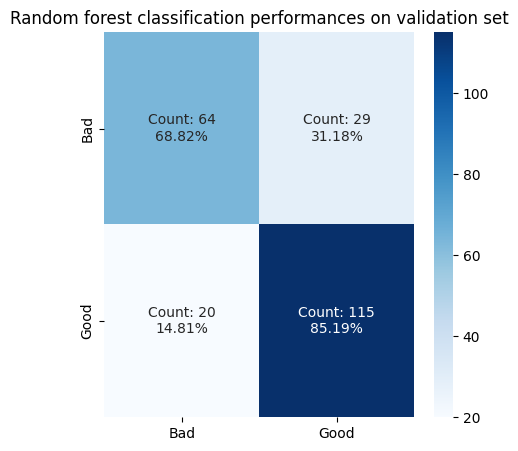

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_validation, rfc.predict(X_validation), 'Random forest classification performances on validation set', ax=ax)

<ipython-input-27-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


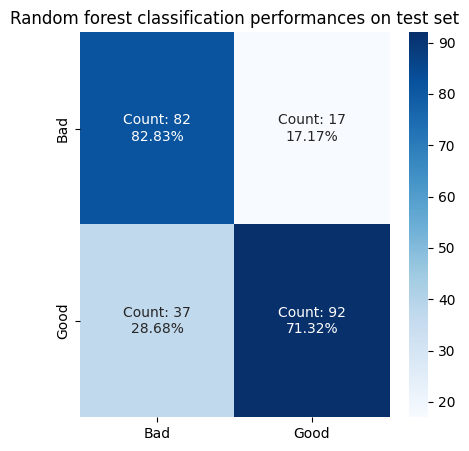

In [ ]:
fig, ax = plt.subplots()
plt.style.use('default')
plot_conmat(y_test, rfc.predict(X_test), 'Random forest classification performances on test set', ax=ax)
plt.savefig('random_forest_classification_singletask.eps', format='eps')

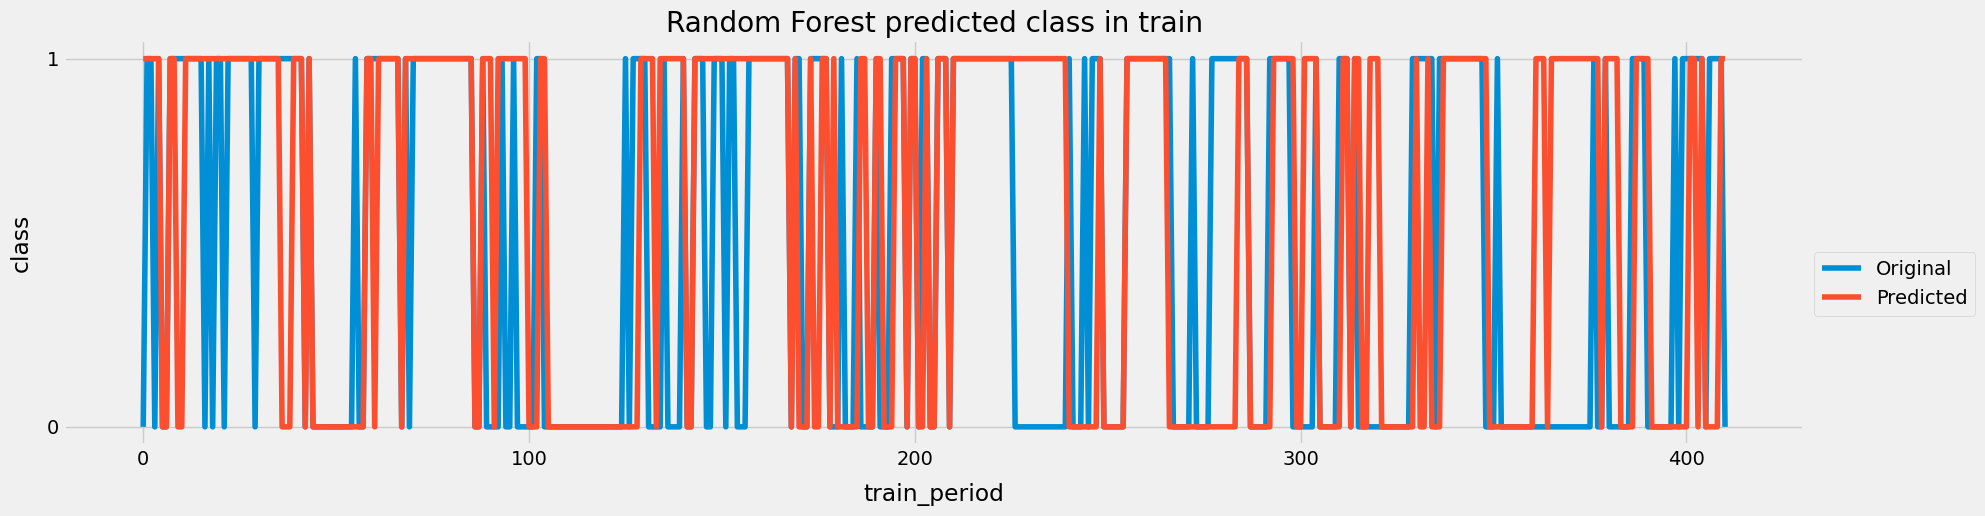

In [ ]:
fig, ax= plt.subplots()
plt.style.use('fivethirtyeight')
plt.plot(y_train, label='Original')
plt.title('Random Forest predicted class in train')
plt.plot(rfc.predict(X_train), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

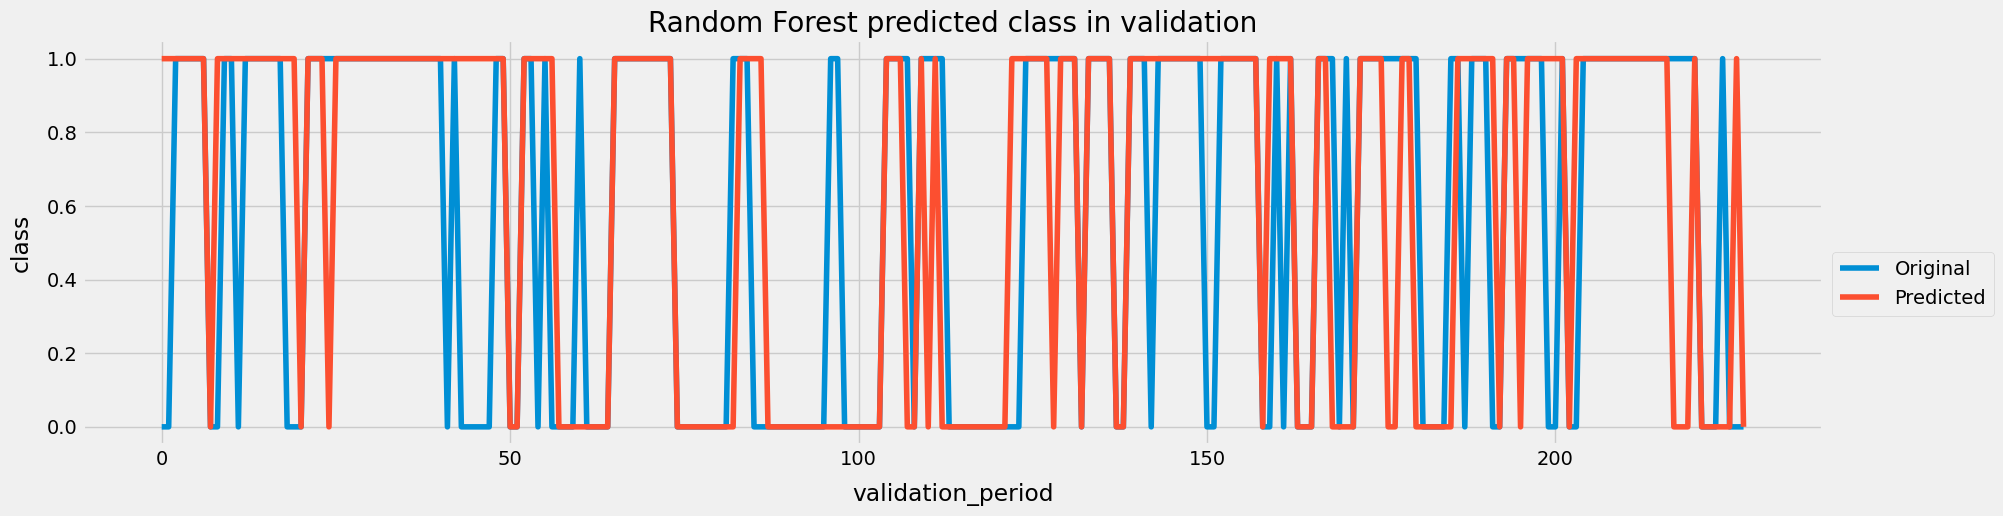

In [ ]:
plt.plot(y_validation, label='Original')
plt.style.use('fivethirtyeight')
plt.title('Random Forest predicted class in validation')
plt.plot(rfc.predict(X_validation), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('validation_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

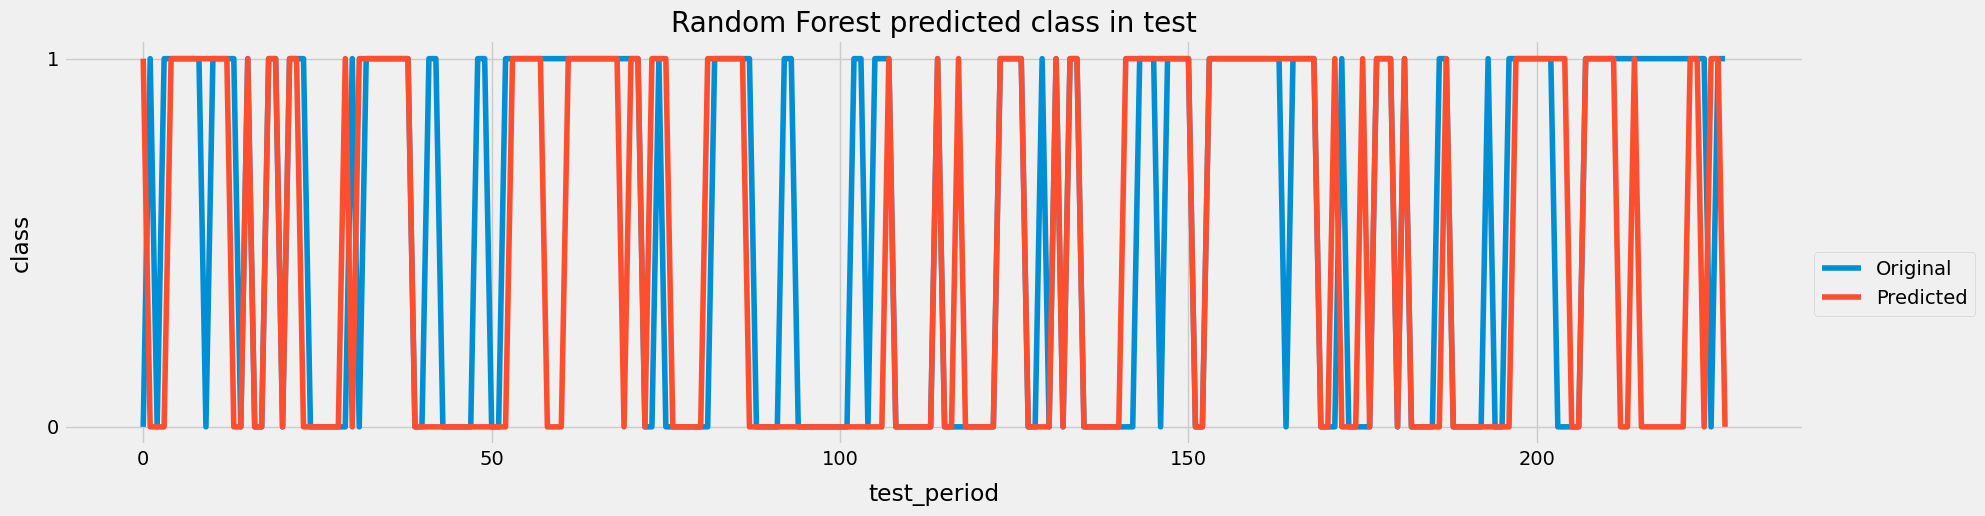

In [ ]:
fig, ax= plt.subplots()
plt.style.use('fivethirtyeight')
#y_test.reset_index(inplace = True, drop = True)
plt.plot(y_test, label='Original')
plt.title('Random Forest predicted class in test')
plt.plot(rfc.predict(X_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Feed Forward

In [ ]:
# 10 for 0(bad), 01 for 1 (good)
y_train_ffnn = np.eye(2)[target_train['mean']]
y_validation_ffnn = np.eye(2)[target_validation['mean']]
y_test_ffnn = np.eye(2)[target_test['mean']]

In [ ]:
tuning_model = feed_forward()

history = tuning_model.fit(X_train, y_train_ffnn, validation_data = (X_validation, y_validation_ffnn), shuffle=False, epochs=1000, verbose=0)

Text(0, 0.5, 'loss')

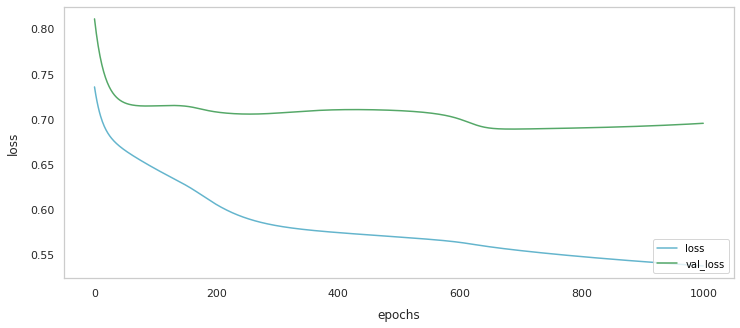

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
y_train_val_ffnn = np.concatenate((y_train_ffnn, y_validation_ffnn))

fitting_times = 10
model = feed_forward()

test_acc = [0, 0]
train_acc = [0, 0]

for i in range(fitting_times):
  model.fit(X_train_validation, y_train_val_ffnn, shuffle=False, epochs=620, verbose=0)

  if (test_acc[1] < model.evaluate(X_test,y_test_ffnn, verbose = 0)[1]):
     test_acc = model.evaluate(X_test,y_test_ffnn, verbose = 0)
     train_acc = model.evaluate(X_train_validation,y_train_val_ffnn, verbose = 0)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4)                 24        
                                                                 
 softmax (Dense)             (None, 2)                 10        
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("FFNN:")
print("      ",model.metrics_names)
print("test: ", np.around(test_acc,3))
print("train: ", np.around(train_acc,3))

FFNN:
       ['loss', 'accuracy']
test:  [0.647 0.697]
train:  [0.542 0.72 ]


13/13 [==============================] - 0s 2ms/step


<ipython-input-13-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


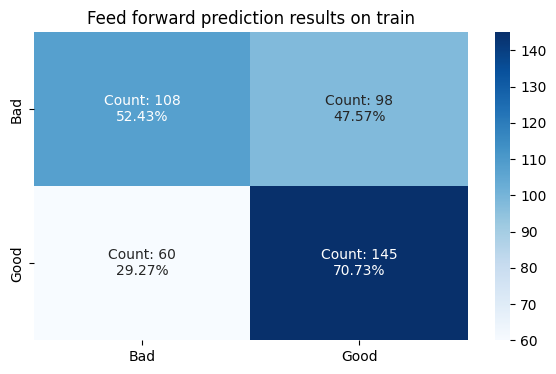

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_train_ffnn.argmax(axis=1), model.predict(X_train).argmax(axis=1), 'Feed forward prediction results on train', ax=ax)

8/8 [==============================] - 0s 6ms/step


<ipython-input-13-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


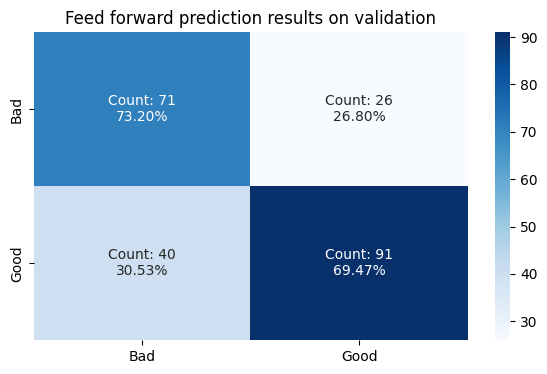

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_validation_ffnn.argmax(axis=1), model.predict(X_validation).argmax(axis=1), 'Feed forward prediction results on validation', ax=ax)

8/8 [==============================] - 0s 2ms/step


<ipython-input-13-bc08fa3efa94>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


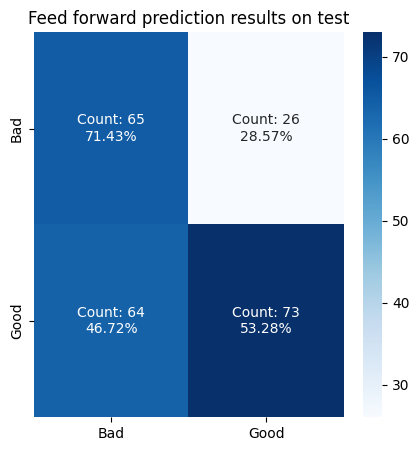

In [ ]:
fig, ax = plt.subplots()
plot_conmat(y_test_ffnn.argmax(axis=1), model.predict(X_test).argmax(axis=1), 'Feed forward prediction results on test', ax=ax)

In [ ]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots()
plt.plot(list(map(lambda x: 0 if x==0 else 1, y_train_ffnn.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in train')
plt.plot(list(map(lambda x: 0 if x==0 else 1, model.predict(X_train).argmax(axis=1))), label='Predicted')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.legend()
plt.show()

In [ ]:
plt.plot(list(map(lambda x: 0 if x==0 else 1, y_validation_ffnn.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in validation')
plt.plot(list(map(lambda x: 0 if x==0 else 1, model.predict(X_validation).argmax(axis=1))), label='Predicted')
plt.legend()
plt.show()

In [ ]:
trues_test = list(map(lambda x: 0 if x==0 else 1, y_test_ffnn.argmax(axis=1)))
preds = list(map(lambda x: 0 if x==0 else 1, model.predict(X_test).argmax(axis=1)))

In [ ]:
fig, ax = plt.subplots()
plt.plot(trues_test, label='Original')
plt.title('Feed forward predicted class in test')
plt.plot(preds, label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## All features with aggregations no snow

In [ ]:
csv_with_aggreg = "./features_with_aggregations.csv"
noSnow_features = pd.read_csv(csv_with_aggreg)
noSnow_features ['date'] = pd.to_datetime(noSnow_features['date'], format="%Y-%m-%d")
#START_DATE = datetime.strptime('2001-01-05', '%Y-%m-%d')
START_DATE = datetime.strptime('2010-09-11', '%Y-%m-%d')
END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
noSnow_features = noSnow_features[(noSnow_features['date'] <= TEST_END_DATE) & 
                                  (noSnow_features['date'] >= START_DATE)]
noSnow_features.reset_index(inplace = True, drop = True)
noSnow_features = noSnow_features[noSnow_features.filter(like=region).columns]
noSnow_features

,cyclostationary_mean_Dora_tg,cyclostationary_mean_Dora_rr,cyclostationary_mean_Dora_tg_1w,cyclostationary_mean_Dora_tg_4w,cyclostationary_mean_Dora_tg_8w,cyclostationary_mean_Dora_tg_12w,cyclostationary_mean_Dora_tg_16w,cyclostationary_mean_Dora_tg_24w,cyclostationary_mean_Dora_rr_1w,cyclostationary_mean_Dora_rr_4w,cyclostationary_mean_Dora_rr_8w,cyclostationary_mean_Dora_rr_12w,cyclostationary_mean_Dora_rr_16w,cyclostationary_mean_Dora_rr_24w
0,-2.056586,-0.765728,-1.960503,-1.563972,-0.243497,-0.424060,-0.393580,-0.427082,-1.213787,0.172794,-0.036513,0.577921,0.750553,0.342657
1,-0.638481,-1.401442,-1.347533,-1.326337,-0.568761,-0.530086,-0.446718,-0.480441,-1.083585,0.046070,-0.095872,0.254632,0.212977,0.174860
2,-1.072260,0.654933,-0.855370,-0.989817,-1.137012,-0.701767,-0.389309,-0.324886,-0.373255,-1.063918,0.017343,0.309887,0.187679,0.293514
3,-1.887335,1.674664,-1.479797,-1.503816,-1.507389,-0.500794,-0.406204,-0.339508,1.164799,-0.299884,0.197791,-0.059802,0.389400,0.450204
4,0.591689,-2.074344,-0.647823,-1.012594,-1.202916,-0.399835,-0.501128,-0.377762,-0.199840,-0.382384,-0.031358,-0.113447,0.374517,0.276783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-1.640702,-0.872469,-3.229628,0.045877,0.669812,0.400442,0.558577,0.402500,0.506986,2.641425,1.657245,1.015477,0.765231,0.527668
421,1.249173,7.477898,-0.195765,-0.309846,0.298093,0.544157,0.672311,0.586771,3.302714,2.424300,2.783684,1.548155,1.288276,0.714104
422,2.077389,-0.487009,1.663281,-0.669015,0.481965,0.626534,0.579566,0.798943,3.495444,2.053494,2.659263,1.525700,1.367549,0.691522
423,0.413046,3.340025,1.245217,-0.543930,0.520874,0.515486,0.621464,0.883805,1.426508,2.268977,3.054436,1.880775,1.395911,0.915727


In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()
train_perc = 0.6
valid_perc = 0.2

#train_perc = 0.475
#valid_perc = 0.2625

features_train = noSnow_features.iloc[:round(len(noSnow_features)*train_perc), :]
scaler_f.fit(features_train)

features_df_scaled = noSnow_features
features_df_scaled[features_df_scaled.columns] = scaler_f.transform(noSnow_features)

features_train = features_df_scaled.iloc[:round(len(noSnow_features)*train_perc), :]
features_validation = features_df_scaled.iloc[round(len(noSnow_features)*train_perc):round(len(noSnow_features)*(train_perc + valid_perc)), :]
features_test = features_df_scaled.iloc[round(len(noSnow_features)*(train_perc + valid_perc)):, :]

features_train_validation = pd.concat([features_train, features_validation])

X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Piemonte_Nord_tg
1: cyclostationary_mean_Piemonte_Nord_rr
2: cyclostationary_mean_Piemonte_Nord_tg_1w
3: cyclostationary_mean_Piemonte_Nord_tg_4w
4: cyclostationary_mean_Piemonte_Nord_tg_8w
5: cyclostationary_mean_Piemonte_Nord_tg_12w
6: cyclostationary_mean_Piemonte_Nord_tg_16w
7: cyclostationary_mean_Piemonte_Nord_tg_24w
8: cyclostationary_mean_Piemonte_Nord_rr_1w
9: cyclostationary_mean_Piemonte_Nord_rr_4w
10: cyclostationary_mean_Piemonte_Nord_rr_8w
11: cyclostationary_mean_Piemonte_Nord_rr_12w
12: cyclostationary_mean_Piemonte_Nord_rr_16w
13: cyclostationary_mean_Piemonte_Nord_rr_24w


In [ ]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 80)

log_regr.fit(X_train, y_train.ravel())
print("Train accuracy logistic regression: ", round(log_regr.score(X_validation, y_validation),3))
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))

Train accuracy logistic regression:  0.576
Test accuracy logistic regression:  0.541


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_validation, y_train_validation)
print("Train accuracy linear regression: ", round(reg.score(X_train_validation, y_train_validation),3))
print("Test accuracy linear regression: ", round(reg.score(X_test, y_test),3))

Train accuracy linear regression:  0.288
Test accuracy linear regression:  0.089


## All features with aggregations ARPA

In [14]:
region

'Ticino'

In [ ]:
START_DATE = datetime.strptime('2001-01-05', '%Y-%m-%d')
#START_DATE = datetime.strptime('2010-09-11', '%Y-%m-%d')
END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')

features_file = "snow/ARPA_csv/snow_" + region + "_with_aggreg_KNN.csv"
features_df_snow = pd.read_csv(features_file)
features_df_snow['Date'] = pd.to_datetime(features_df_snow['Date'], format="%Y-%m-%d")
features_df_snow = features_df_snow[(features_df_snow['Date'] <= END_DATE) & 
                                  (features_df_snow['Date'] >= START_DATE)]
features_df_snow.reset_index(inplace = True, drop = True)

csv_with_aggreg = "./features_with_aggregations.csv"
noSnow_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})
noSnow_features ['date'] = pd.to_datetime(noSnow_features['date'], format="%Y-%m-%d")
noSnow_features = noSnow_features[(noSnow_features['date'] <= END_DATE) & 
                                  (noSnow_features['date'] >= START_DATE)]
noSnow_features.reset_index(inplace = True, drop = True)
noSnow_features = noSnow_features[noSnow_features.filter(like=region).columns]

features_df = pd.concat([features_df_snow, noSnow_features], axis = 1)
features_df = features_df.iloc[:,3:]
features_df

,cyclostationary_mean_snow,cyclostationary_mean_snow_1w,cyclostationary_mean_snow_4w,cyclostationary_mean_snow_8w,cyclostationary_mean_snow_12w,cyclostationary_mean_snow_16w,cyclostationary_mean_snow_24w,cyclostationary_mean_Dora_tg,cyclostationary_mean_Dora_rr,cyclostationary_mean_Dora_tg_1w,...,cyclostationary_mean_Dora_tg_8w,cyclostationary_mean_Dora_tg_12w,cyclostationary_mean_Dora_tg_16w,cyclostationary_mean_Dora_tg_24w,cyclostationary_mean_Dora_rr_1w,cyclostationary_mean_Dora_rr_4w,cyclostationary_mean_Dora_rr_8w,cyclostationary_mean_Dora_rr_12w,cyclostationary_mean_Dora_rr_16w,cyclostationary_mean_Dora_rr_24w
0,-0.257812,-0.202567,-0.081027,-0.043948,-0.215724,0.547014,4.824480,-2.056586,-0.765728,-1.960503,...,-0.243497,-0.424060,-0.393580,-0.427082,-1.213787,0.172794,-0.036513,0.577921,0.750553,0.342657
1,0.062500,-0.097656,-0.068527,-0.116369,-0.126631,0.260304,3.875180,-0.638481,-1.401442,-1.347533,...,-0.568761,-0.530086,-0.446718,-0.480441,-1.083585,0.046070,-0.095872,0.254632,0.212977,0.174860
2,-0.900391,-0.418945,-0.248605,-0.144364,-0.052691,-0.152350,2.792867,-1.072260,0.654933,-0.855370,...,-1.137012,-0.701767,-0.389309,-0.324886,-0.373255,-1.063918,0.017343,0.309887,0.187679,0.293514
3,-1.245982,-1.073186,-0.497801,-0.276556,-0.127262,-0.273208,2.194881,-1.887335,1.674664,-1.479797,...,-1.507389,-0.500794,-0.406204,-0.339508,1.164799,-0.299884,0.197791,-0.059802,0.389400,0.450204
4,-0.712500,-0.979241,-0.610837,-0.355723,-0.245531,-0.329458,1.366459,0.591689,-2.074344,-0.647823,...,-1.202916,-0.399835,-0.501128,-0.377762,-0.199840,-0.382384,-0.031358,-0.113447,0.374517,0.276783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,50.683594,44.537188,25.287698,26.052566,27.810489,28.758919,28.822996,-1.640702,-0.872469,-3.229628,...,0.669812,0.400442,0.558577,0.402500,0.506986,2.641425,1.657245,1.015477,0.765231,0.527668
421,47.827455,49.255525,32.058546,27.830974,29.038208,29.703829,29.554720,1.249173,7.477898,-0.195765,...,0.298093,0.544157,0.672311,0.586771,3.302714,2.424300,2.783684,1.548155,1.288276,0.714104
422,39.400000,43.613728,35.919835,28.780159,29.628995,30.146941,29.314188,2.077389,-0.487009,1.663281,...,0.481965,0.626534,0.579566,0.798943,3.495444,2.053494,2.659263,1.525700,1.367549,0.691522
423,34.456250,36.928125,42.151616,29.206285,29.847992,30.299244,27.793845,0.413046,3.340025,1.245217,...,0.520874,0.515486,0.621464,0.883805,1.426508,2.268977,3.054436,1.880775,1.395911,0.915727


In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()
train_perc = 0.6
valid_perc = 0.2

#255
features_train = features_df.iloc[:round(len(features_df)*train_perc), :]
scaler_f.fit(features_train)

features_df_scaled = features_df
features_df_scaled[features_df_scaled.columns] = scaler_f.transform(features_df)

features_train = features_df_scaled.iloc[:round(len(features_df)*train_perc), :]
features_validation = features_df_scaled.iloc[round(len(features_df)*train_perc):round(len(features_df)*(train_perc + valid_perc)), :]
features_test = features_df_scaled.iloc[round(len(features_df)*(train_perc + valid_perc)):, :]

features_train_validation = pd.concat([features_train, features_validation])

X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()
train_perc = 0.475
valid_perc = 0.2625

features_train = features_df.iloc[:round(len(features_df)*train_perc), :]
scaler_f.fit(features_train)

features_df_scaled = features_df
features_df_scaled[features_df_scaled.columns] = scaler_f.transform(features_df)

features_train = features_df_scaled.iloc[:round(len(features_df)*train_perc)-1, :]
features_validation = features_df_scaled.iloc[round(len(features_df)*train_perc)-1:round(len(features_df)*(train_perc + valid_perc)), :]
features_test = features_df_scaled.iloc[round(len(features_df)*(train_perc + valid_perc)):, :]

features_train_validation = pd.concat([features_train, features_validation])

X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_snow
1: cyclostationary_mean_snow_1w
2: cyclostationary_mean_snow_4w
3: cyclostationary_mean_snow_8w
4: cyclostationary_mean_snow_12w
5: cyclostationary_mean_snow_16w
6: cyclostationary_mean_snow_24w
7: cyclostationary_mean_Adda_tg
8: cyclostationary_mean_Adda_rr
9: cyclostationary_mean_Adda_tg_1w
10: cyclostationary_mean_Adda_tg_4w
11: cyclostationary_mean_Adda_tg_8w
12: cyclostationary_mean_Adda_tg_12w
13: cyclostationary_mean_Adda_tg_16w
14: cyclostationary_mean_Adda_tg_24w
15: cyclostationary_mean_Adda_rr_1w
16: cyclostationary_mean_Adda_rr_4w
17: cyclostationary_mean_Adda_rr_8w
18: cyclostationary_mean_Adda_rr_12w
19: cyclostationary_mean_Adda_rr_16w
20: cyclostationary_mean_Adda_rr_24w


In [ ]:
output = { "X" : X_train, "Y" : target_train.values}

with open("./pickles/" + region + "_snow_ARPA.pickle", "wb") as f:
    pickle.dump(output, f)

In [ ]:
%run "./scripts/main.py" --classification 0 --filename "./pickles/Dora_snow_ARPA.pickle" --backward 'f' --k 13

In [ ]:
chosen_features_ids = [0, 12, 1] # Ticino: [7, 1, 14, 5, 0, 4]  # Piemonte Sud [18, 2, 19, 5, 3, 7] 

X_train = features_train.iloc[:,chosen_features_ids].values
X_validation = features_validation.iloc[:,chosen_features_ids].values
X_test = features_test.iloc[:,chosen_features_ids].values

X_train_validation = pd.concat([features_train.iloc[:,chosen_features_ids], features_validation.iloc[:,chosen_features_ids]]).values

chosen_features = features_train.iloc[:,chosen_features_ids]
idx_dic = {}
print("Chosen features with CMI feature selection for " + region + " :\n")
for col in chosen_features.columns:
    idx_dic[col] = chosen_features.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

Chosen features with CMI feature selection for Ticino :

0: cyclostationary_mean_snow
1: cyclostationary_mean_Ticino_tg_12w
2: cyclostationary_mean_snow_1w


In [ ]:
from sklearn.linear_model import LogisticRegression # 0.645 [0, 7, 16, 1]

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))

Train accuracy logistic regression:  0.691
Test accuracy logistic regression:  0.576


## All features with aggregations IT-SNOW

In [ ]:
features_file = "snow/IT-SNOW/csv_HS/" + region + "_aggreg_HS.csv"
features_df_snow = pd.read_csv(features_file)

csv_with_aggreg = "./features_with_aggregations.csv"
noSnow_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})
noSnow_features ['date'] = pd.to_datetime(noSnow_features['date'], format="%Y-%m-%d")
START_DATE = datetime.strptime('2010-09-11', '%Y-%m-%d')
END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
noSnow_features = noSnow_features[(noSnow_features['date'] <= END_DATE) & 
                                  (noSnow_features['date'] >= START_DATE)]
noSnow_features.reset_index(inplace = True, drop = True)
noSnow_features = noSnow_features[noSnow_features.filter(like=region).columns]

features_df = pd.concat([features_df_snow, noSnow_features], axis = 1)
features_df = features_df.iloc[:,3:]
features_df

,cyclostationary_mean_HS,cyclostationary_mean_HS_1w,cyclostationary_mean_HS_4w,cyclostationary_mean_HS_8w,cyclostationary_mean_HS_12w,cyclostationary_mean_HS_16w,cyclostationary_mean_HS_24w,cyclostationary_mean_Dora_tg,cyclostationary_mean_Dora_rr,cyclostationary_mean_Dora_tg_1w,...,cyclostationary_mean_Dora_tg_8w,cyclostationary_mean_Dora_tg_12w,cyclostationary_mean_Dora_tg_16w,cyclostationary_mean_Dora_tg_24w,cyclostationary_mean_Dora_rr_1w,cyclostationary_mean_Dora_rr_4w,cyclostationary_mean_Dora_rr_8w,cyclostationary_mean_Dora_rr_12w,cyclostationary_mean_Dora_rr_16w,cyclostationary_mean_Dora_rr_24w
0,0.832925,0.832925,0.832925,0.832925,0.832925,0.832925,0.832925,-2.056586,-0.765728,-1.960503,...,-0.243497,-0.424060,-0.393580,-0.427082,-1.213787,0.172794,-0.036513,0.577921,0.750553,0.342657
1,1.484390,1.158658,1.158658,1.158658,1.158658,1.158658,1.158658,-0.638481,-1.401442,-1.347533,...,-0.568761,-0.530086,-0.446718,-0.480441,-1.083585,0.046070,-0.095872,0.254632,0.212977,0.174860
2,1.043162,1.263776,1.120159,1.120159,1.120159,1.120159,1.120159,-1.072260,0.654933,-0.855370,...,-1.137012,-0.701767,-0.389309,-0.324886,-0.373255,-1.063918,0.017343,0.309887,0.187679,0.293514
3,2.674226,1.858694,1.508676,1.508676,1.508676,1.508676,1.508676,-1.887335,1.674664,-1.479797,...,-1.507389,-0.500794,-0.406204,-0.339508,1.164799,-0.299884,0.197791,-0.059802,0.389400,0.450204
4,5.093430,3.883828,2.225627,2.225627,2.225627,2.225627,2.225627,0.591689,-2.074344,-0.647823,...,-1.202916,-0.399835,-0.501128,-0.377762,-0.199840,-0.382384,-0.031358,-0.113447,0.374517,0.276783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-4.188129,-4.915247,-5.556869,-4.294507,-3.311968,-2.360203,9.531420,-1.640702,-0.872469,-3.229628,...,0.669812,0.400442,0.558577,0.402500,0.506986,2.641425,1.657245,1.015477,0.765231,0.527668
421,2.966322,-0.610904,-4.141911,-3.858011,-2.989966,-2.370826,7.416793,1.249173,7.477898,-0.195765,...,0.298093,0.544157,0.672311,0.586771,3.302714,2.424300,2.783684,1.548155,1.288276,0.714104
422,0.466723,1.716522,-2.698026,-3.563115,-2.909690,-2.433070,5.349667,2.077389,-0.487009,1.663281,...,0.481965,0.626534,0.579566,0.798943,3.495444,2.053494,2.659263,1.525700,1.367549,0.691522
423,30.001193,15.233958,4.720749,0.034906,-0.498028,-0.663100,4.761286,0.413046,3.340025,1.245217,...,0.520874,0.515486,0.621464,0.883805,1.426508,2.268977,3.054436,1.880775,1.395911,0.915727


In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()
train_perc = 0.6
valid_perc = 0.2

#255
features_train = features_df.iloc[:round(len(features_df)*train_perc), :]
scaler_f.fit(features_train)

features_df_scaled = features_df
features_df_scaled[features_df_scaled.columns] = scaler_f.transform(features_df)

features_train = features_df_scaled.iloc[:round(len(features_df)*train_perc), :]
features_validation = features_df_scaled.iloc[round(len(features_df)*train_perc):round(len(features_df)*(train_perc + valid_perc)), :]
features_test = features_df_scaled.iloc[round(len(features_df)*(train_perc + valid_perc)):, :]

features_train_validation = pd.concat([features_train, features_validation])

X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_snow
1: cyclostationary_mean_snow_1w
2: cyclostationary_mean_snow_4w
3: cyclostationary_mean_snow_8w
4: cyclostationary_mean_snow_12w
5: cyclostationary_mean_snow_16w
6: cyclostationary_mean_snow_24w
7: cyclostationary_mean_Piemonte_Nord_tg
8: cyclostationary_mean_Piemonte_Nord_rr
9: cyclostationary_mean_Piemonte_Nord_tg_1w
10: cyclostationary_mean_Piemonte_Nord_tg_4w
11: cyclostationary_mean_Piemonte_Nord_tg_8w
12: cyclostationary_mean_Piemonte_Nord_tg_12w
13: cyclostationary_mean_Piemonte_Nord_tg_16w
14: cyclostationary_mean_Piemonte_Nord_tg_24w
15: cyclostationary_mean_Piemonte_Nord_rr_1w
16: cyclostationary_mean_Piemonte_Nord_rr_4w
17: cyclostationary_mean_Piemonte_Nord_rr_8w
18: cyclostationary_mean_Piemonte_Nord_rr_12w
19: cyclostationary_mean_Piemonte_Nord_rr_16w
20: cyclostationary_mean_Piemonte_Nord_rr_24w


In [ ]:
output = { "X" : X_train, "Y" : target_train.values}

with open("./pickles/" + region + "_snow_IT-SNOW.pickle", "wb") as f:
    pickle.dump(output, f)

In [ ]:
%run "./scripts/main.py" --classification 0 --filename "./pickles/Piemonte_Sud_snow_IT-SNOW.pickle" --backward 'f' --k 5

Current Delta: 0.005
Current Threshold: 0.016193861733211773
----- MI Scores -----
[(9, 0.24273888701392882), (7, 0.18608897145353856), (10, 0.16288921839565068), (11, 0.11128063776601353), (3, 0.08402524909899886), (4, 0.0834739235067965), (19, 0.07684993345244971), (2, 0.07663749135948558), (15, 0.07492370967025294), (16, 0.07233171325611963), (14, 0.06894592921532552), (1, 0.06257962225132863), (17, 0.05584191484606704), (13, 0.05546677478558663), (0, 0.05521337408765276), (18, 0.04586400796335143), (20, 0.04479411751617243), (6, 0.0444906880698729), (5, 0.030980826985740003), (12, 0.025708903786361124), (8, 0.006315235042443647)]
Best MI score: 0.24273888701392882
Adding first best original feature: 9
CMI: 0.03497349310754966
CMI: 0.06409090807996326
CMI: 0.05165600773180762
CMI: 0.028514354472336467
CMI: 0.03556652522974452
CMI: 0.01286472766445168
CMI: 0.031669880757119295
CMI: 0.00236953680007862
CMI: 0.038126950415446004
CMI: 0.06810488198225778
CMI: 0.010403838191386794
CMI: 0

In [ ]:
chosen_features_ids = [9, 14, 6, 5]

X_train = features_train.iloc[:,chosen_features_ids].values
X_validation = features_validation.iloc[:,chosen_features_ids].values
X_test = features_test.iloc[:,chosen_features_ids].values

X_train_validation = pd.concat([features_train.iloc[:,chosen_features_ids], features_validation.iloc[:,chosen_features_ids]]).values

chosen_features = features_train.iloc[:,chosen_features_ids]
idx_dic = {}
print("Chosen features with CMI feature selection for " + region + " :\n")
for col in chosen_features.columns:
    idx_dic[col] = chosen_features.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

Chosen features with CMI feature selection for Piemonte_Sud :

0: cyclostationary_mean_Piemonte_Sud_tg_1w
1: cyclostationary_mean_Piemonte_Sud_tg_24w
2: cyclostationary_mean_snow_24w
3: cyclostationary_mean_snow_16w


In [ ]:
from sklearn.linear_model import LogisticRegression #0.529

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))

Train accuracy logistic regression:  0.688
Test accuracy logistic regression:  0.588


## Correlation 

In [ ]:
region = "Piemonte_Nord"

In [ ]:
features_file = "snow/IT-SNOW/csv_HS/" + region + "_aggreg_snow.csv"
features_df_snow = pd.read_csv(features_file)

features_file_ARPA = "snow/IT-SNOW/csv_HS/" + region + "_aggreg_snow_ARPA.csv"
features_df_snow_ARPA = pd.read_csv(features_file_ARPA)
features_df_snow_ARPA = features_df_snow_ARPA.iloc[:,3:]
features_df_snow_ARPA = features_df_snow_ARPA.add_suffix('ARPA')

csv_with_aggreg = "./features_with_aggregations.csv"
noSnow_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})
noSnow_features ['date'] = pd.to_datetime(noSnow_features['date'], format="%Y-%m-%d")
START_DATE = datetime.strptime('2010-09-11', '%Y-%m-%d')
END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
noSnow_features = noSnow_features[(noSnow_features['date'] <= END_DATE) & 
                                  (noSnow_features['date'] >= START_DATE)]
noSnow_features.reset_index(inplace = True, drop = True)
noSnow_features = noSnow_features[noSnow_features.filter(like=region).columns]

features_df = pd.concat([features_df_snow, noSnow_features], axis = 1)
features_df = pd.concat([features_df, features_df_snow_ARPA], axis = 1)
features_df = features_df.iloc[:,3:]
features_df

,cyclostationary_mean_snow,cyclostationary_mean_snow_1w,cyclostationary_mean_snow_4w,cyclostationary_mean_snow_8w,cyclostationary_mean_snow_12w,cyclostationary_mean_snow_16w,cyclostationary_mean_snow_24w,cyclostationary_mean_Piemonte_Nord_tg,cyclostationary_mean_Piemonte_Nord_rr,cyclostationary_mean_Piemonte_Nord_tg_1w,...,cyclostationary_mean_Piemonte_Nord_rr_12w,cyclostationary_mean_Piemonte_Nord_rr_16w,cyclostationary_mean_Piemonte_Nord_rr_24w,cyclostationary_mean_snowARPA,cyclostationary_mean_snow_1wARPA,cyclostationary_mean_snow_4wARPA,cyclostationary_mean_snow_8wARPA,cyclostationary_mean_snow_12wARPA,cyclostationary_mean_snow_16wARPA,cyclostationary_mean_snow_24wARPA
0,-0.456609,-0.456609,-0.456609,-0.456609,-0.456609,-0.456609,-0.456609,-2.362808,0.609206,-2.069081,...,0.632319,0.660778,0.413797,-0.013021,-0.013021,-0.013021,-0.013021,-0.013021,-0.013021,-0.013021
1,-0.339304,-0.397957,-0.397957,-0.397957,-0.397957,-0.397957,-0.397957,-0.944270,-2.367751,-1.653539,...,0.487202,0.157043,0.276467,0.155907,0.071443,0.071443,0.071443,0.071443,0.071443,0.071443
2,-0.384718,-0.362011,-0.393544,-0.393544,-0.393544,-0.393544,-0.393544,-1.069262,0.339594,-1.006766,...,0.463825,0.175156,0.303173,-0.341283,-0.092688,-0.066132,-0.066132,-0.066132,-0.066132,-0.066132
3,0.083224,-0.150747,-0.274352,-0.274352,-0.274352,-0.274352,-0.274352,-1.664069,3.759321,-1.366666,...,0.126332,0.471194,0.508624,-1.641927,-0.991605,-0.460081,-0.460081,-0.460081,-0.460081,-0.460081
4,0.379225,0.231225,-0.143636,-0.143636,-0.143636,-0.143636,-0.143636,-0.380368,-0.788386,-1.022219,...,0.102765,0.538995,0.357210,-0.700231,-1.171079,-0.508111,-0.508111,-0.508111,-0.508111,-0.508111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-3.313290,-2.835732,-3.065707,-1.892203,-1.384139,-1.129857,2.557173,-0.506590,1.219459,-1.665153,...,0.790719,0.603462,0.316432,69.604898,54.181760,15.785011,8.518563,5.922672,4.529960,5.866449
421,2.765573,-0.273858,-2.205656,-1.576364,-1.136510,-0.969446,1.715290,2.272138,7.020365,0.882774,...,1.245361,1.051875,0.558590,61.172694,65.388796,29.195592,15.319291,10.628264,8.126975,7.413873
422,19.891302,11.328437,2.520177,0.650564,0.415208,0.201838,1.634733,1.537850,0.505822,1.904994,...,1.283314,1.144928,0.621885,35.105263,48.138978,38.101605,19.255694,13.332515,10.192144,7.532292
423,28.285611,24.088457,9.054205,3.836633,2.603527,1.897684,2.018778,1.413162,0.347862,1.475506,...,1.443213,1.074958,0.694678,62.816216,48.960740,53.491538,26.396877,18.131880,13.887583,9.210497


In [ ]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_snow
1: cyclostationary_mean_snow_1w
2: cyclostationary_mean_snow_4w
3: cyclostationary_mean_snow_8w
4: cyclostationary_mean_snow_12w
5: cyclostationary_mean_snow_16w
6: cyclostationary_mean_snow_24w
7: cyclostationary_mean_Piemonte_Nord_tg
8: cyclostationary_mean_Piemonte_Nord_rr
9: cyclostationary_mean_Piemonte_Nord_tg_1w
10: cyclostationary_mean_Piemonte_Nord_tg_4w
11: cyclostationary_mean_Piemonte_Nord_tg_8w
12: cyclostationary_mean_Piemonte_Nord_tg_12w
13: cyclostationary_mean_Piemonte_Nord_tg_16w
14: cyclostationary_mean_Piemonte_Nord_tg_24w
15: cyclostationary_mean_Piemonte_Nord_rr_1w
16: cyclostationary_mean_Piemonte_Nord_rr_4w
17: cyclostationary_mean_Piemonte_Nord_rr_8w
18: cyclostationary_mean_Piemonte_Nord_rr_12w
19: cyclostationary_mean_Piemonte_Nord_rr_16w
20: cyclostationary_mean_Piemonte_Nord_rr_24w
21: cyclostationary_mean_snowARPA
22: cyclostationary_mean_snow_1wARPA
23: cyclostationary_mean_snow_4wARPA
24: cyclostationary_mean_snow_8wARPA
25: 

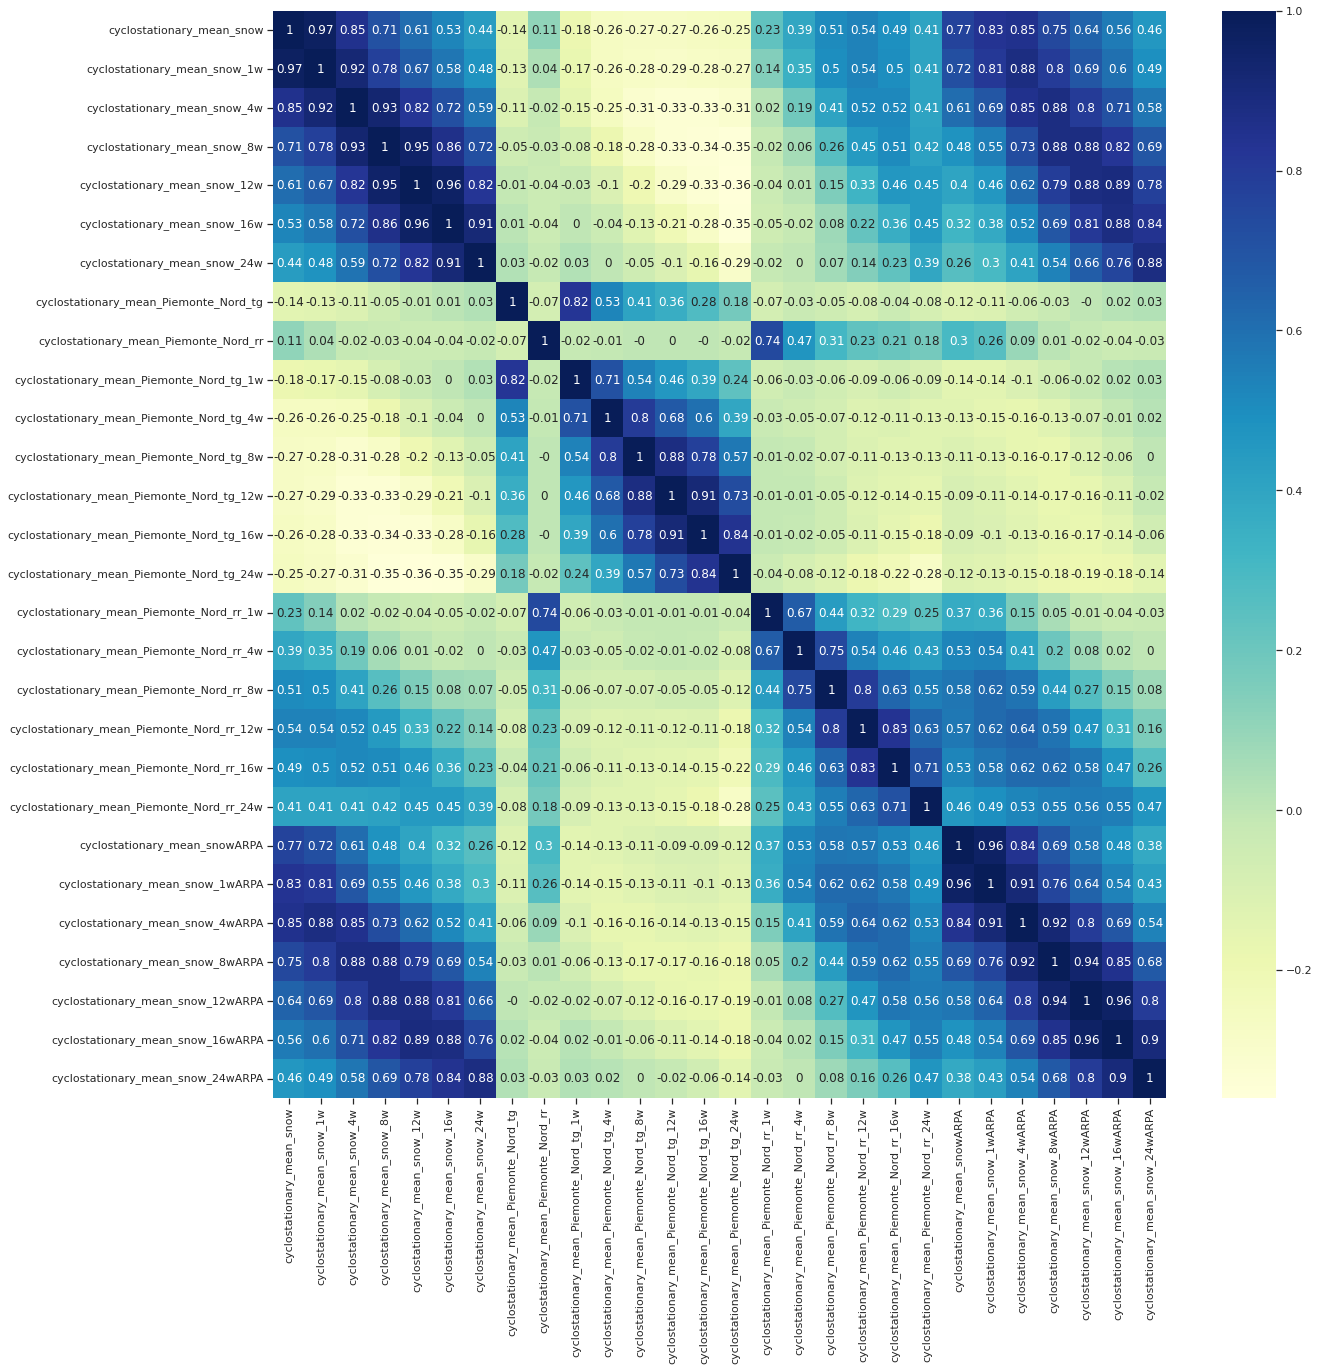

In [ ]:
cormat = features_df.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(cormat,2), annot=True, ax=ax, cmap="YlGnBu")

ax.set_facecolor('white')
sns.set_style('ticks')
# plt.savefig("correlation_matrix_features.jpg", bbox_inches = 'tight')

## SWE feature from IT-SNOW

In [ ]:
features_file = "snow/IT-SNOW/csv_SWE/" + region + "_aggreg_SWE.csv"
features_df_snow = pd.read_csv(features_file)

csv_with_aggreg = "./features_with_aggregations.csv"
noSnow_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})
noSnow_features ['date'] = pd.to_datetime(noSnow_features['date'], format="%Y-%m-%d")
START_DATE = datetime.strptime('2010-09-11', '%Y-%m-%d')
END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
noSnow_features = noSnow_features[(noSnow_features['date'] <= END_DATE) & 
                                  (noSnow_features['date'] >= START_DATE)]
noSnow_features.reset_index(inplace = True, drop = True)
noSnow_features = noSnow_features[noSnow_features.filter(like=region).columns]

features_df = pd.concat([features_df_snow, noSnow_features], axis = 1)
features_df = features_df.iloc[:,3:]
features_df

,cyclostationary_mean_SWE,cyclostationary_mean_SWE_1w,cyclostationary_mean_SWE_4w,cyclostationary_mean_SWE_8w,cyclostationary_mean_SWE_12w,cyclostationary_mean_SWE_16w,cyclostationary_mean_SWE_24w,cyclostationary_mean_Piemonte_Sud_tg,cyclostationary_mean_Piemonte_Sud_rr,cyclostationary_mean_Piemonte_Sud_tg_1w,...,cyclostationary_mean_Piemonte_Sud_tg_8w,cyclostationary_mean_Piemonte_Sud_tg_12w,cyclostationary_mean_Piemonte_Sud_tg_16w,cyclostationary_mean_Piemonte_Sud_tg_24w,cyclostationary_mean_Piemonte_Sud_rr_1w,cyclostationary_mean_Piemonte_Sud_rr_4w,cyclostationary_mean_Piemonte_Sud_rr_8w,cyclostationary_mean_Piemonte_Sud_rr_12w,cyclostationary_mean_Piemonte_Sud_rr_16w,cyclostationary_mean_Piemonte_Sud_rr_24w
0,-0.233900,-0.233900,-0.233900,-0.233900,-0.233900,-0.233900,-0.233900,-2.281732,1.039715,-2.026907,...,-0.377513,-0.462027,-0.474418,-0.458313,-0.154528,0.895574,0.165596,0.503390,0.470533,0.200459
1,-0.164463,-0.199182,-0.199182,-0.199182,-0.199182,-0.199182,-0.199182,-0.754933,-1.855250,-1.518332,...,-0.664000,-0.606061,-0.532617,-0.565216,-0.407768,0.355814,0.005855,0.533346,0.103366,0.085258
2,-0.127393,-0.145928,-0.175252,-0.175252,-0.175252,-0.175252,-0.175252,-0.777204,-0.085150,-0.766069,...,-1.063933,-0.770216,-0.437222,-0.432215,-0.970200,-0.629770,0.112166,0.581753,0.080745,0.097527
3,-0.083503,-0.105448,-0.152315,-0.152315,-0.152315,-0.152315,-0.152315,-1.541876,4.907825,-1.159540,...,-1.461601,-0.592542,-0.465018,-0.412931,2.411338,0.531674,0.787117,0.377869,0.420095,0.378012
4,-0.090465,-0.086984,-0.139945,-0.139945,-0.139945,-0.139945,-0.139945,-0.356581,0.151715,-0.949229,...,-1.296123,-0.525247,-0.555115,-0.474452,2.529770,0.831771,0.844113,0.354577,0.568424,0.293436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-8.581411,-6.401988,-4.739054,-2.710952,-2.002014,-2.315357,-2.624732,-0.736397,2.480934,-1.431574,...,1.521528,1.279487,1.249246,0.851813,2.520393,2.403209,0.986369,0.506423,0.462853,0.257313
421,-6.335185,-7.458298,-5.905970,-3.405811,-2.426949,-2.399290,-3.085559,2.301092,8.886208,0.782348,...,1.327393,1.431893,1.386366,1.045069,5.683571,2.609097,2.188596,1.119018,0.922848,0.567891
422,28.800225,11.232520,0.583632,-0.192367,-0.179000,-0.456858,-2.474928,2.065085,1.624722,2.183088,...,1.411656,1.480489,1.367661,1.278405,5.255465,2.966980,2.356107,1.317279,1.073615,0.638598
423,46.660390,37.730308,11.264291,5.007177,3.428118,2.465842,-1.172428,1.667927,-1.694247,1.866506,...,1.455791,1.400032,1.424008,1.412016,-0.034762,2.771494,2.378699,1.332297,0.863209,0.577978


In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()
train_perc = 0.6
valid_perc = 0.2

features_train = features_df.iloc[:round(len(features_df)*train_perc), :]
scaler_f.fit(features_train)

features_df_scaled = features_df
features_df_scaled[features_df_scaled.columns] = scaler_f.transform(features_df)

features_train = features_df_scaled.iloc[:round(len(features_df)*train_perc), :]
features_validation = features_df_scaled.iloc[round(len(features_df)*train_perc):round(len(features_df)*(train_perc + valid_perc)), :]
features_test = features_df_scaled.iloc[round(len(features_df)*(train_perc + valid_perc)):, :]

features_train_validation = pd.concat([features_train, features_validation])

X_train = features_train.values
X_validation = features_validation.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_SWE
1: cyclostationary_mean_SWE_1w
2: cyclostationary_mean_SWE_4w
3: cyclostationary_mean_SWE_8w
4: cyclostationary_mean_SWE_12w
5: cyclostationary_mean_SWE_16w
6: cyclostationary_mean_SWE_24w
7: cyclostationary_mean_Piemonte_Sud_tg
8: cyclostationary_mean_Piemonte_Sud_rr
9: cyclostationary_mean_Piemonte_Sud_tg_1w
10: cyclostationary_mean_Piemonte_Sud_tg_4w
11: cyclostationary_mean_Piemonte_Sud_tg_8w
12: cyclostationary_mean_Piemonte_Sud_tg_12w
13: cyclostationary_mean_Piemonte_Sud_tg_16w
14: cyclostationary_mean_Piemonte_Sud_tg_24w
15: cyclostationary_mean_Piemonte_Sud_rr_1w
16: cyclostationary_mean_Piemonte_Sud_rr_4w
17: cyclostationary_mean_Piemonte_Sud_rr_8w
18: cyclostationary_mean_Piemonte_Sud_rr_12w
19: cyclostationary_mean_Piemonte_Sud_rr_16w
20: cyclostationary_mean_Piemonte_Sud_rr_24w


In [ ]:
output = { "X" : X_train, "Y" : target_train.values}

with open("./pickles/" + region + "_snow_IT-SNOW_SWE.pickle", "wb") as f:
    pickle.dump(output, f)

In [ ]:
%run "./scripts/main.py" --classification 0 --filename "./pickles/Piemonte_Nord_snow_IT-SNOW_SWE.pickle" --backward 'f' --k 5

In [ ]:
chosen_features_ids = [9, 14, 3, 4, 5]

X_train = features_train.iloc[:,chosen_features_ids].values
X_validation = features_validation.iloc[:,chosen_features_ids].values
X_test = features_test.iloc[:,chosen_features_ids].values

X_train_validation = pd.concat([features_train.iloc[:,chosen_features_ids], features_validation.iloc[:,chosen_features_ids]]).values

chosen_features = features_train.iloc[:,chosen_features_ids]
idx_dic = {}
print("Chosen features with CMI feature selection for " + region + " :\n")
for col in chosen_features.columns:
    idx_dic[col] = chosen_features.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

Chosen features with CMI feature selection for Piemonte_Nord :

0: cyclostationary_mean_Piemonte_Nord_tg_1w
1: cyclostationary_mean_Piemonte_Nord_tg_24w
2: cyclostationary_mean_SWE_8w
3: cyclostationary_mean_SWE_12w
4: cyclostationary_mean_SWE_16w


In [ ]:
from sklearn.linear_model import LogisticRegression #0.529

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train_validation, y_train_validation.ravel())
print("Train accuracy logistic regression: ", round(log_regr.score(X_train_validation, y_train_validation),3))
print("Test accuracy logistic regression: ", round(log_regr.score(X_test, y_test),3))

Train accuracy logistic regression:  0.756
Test accuracy logistic regression:  0.553


## Correlation between SWE and Snow Depth HS

In [ ]:
region = "Piemonte_Sud"

In [ ]:
features_file = "snow/IT-SNOW/csv_HS/" + region + "_aggreg_snow.csv"
features_df_snow = pd.read_csv(features_file)

features_file_SWE = "snow/IT-SNOW/csv_SWE/" + region + "_aggreg_SWE.csv"
features_df_snow_SWE = pd.read_csv(features_file_SWE)
features_df_snow_SWE = features_df_snow_SWE.iloc[:,3:]

features_df = pd.concat([features_df_snow, features_df_snow_SWE], axis = 1)
features_df = features_df.iloc[:,3:]
features_df

,cyclostationary_mean_snow,cyclostationary_mean_snow_1w,cyclostationary_mean_snow_4w,cyclostationary_mean_snow_8w,cyclostationary_mean_snow_12w,cyclostationary_mean_snow_16w,cyclostationary_mean_snow_24w,cyclostationary_mean_SWE,cyclostationary_mean_SWE_1w,cyclostationary_mean_SWE_4w,cyclostationary_mean_SWE_8w,cyclostationary_mean_SWE_12w,cyclostationary_mean_SWE_16w,cyclostationary_mean_SWE_24w
0,-0.060864,-0.060864,-0.060864,-0.060864,-0.060864,-0.060864,-0.060864,-0.233900,-0.233900,-0.233900,-0.233900,-0.233900,-0.233900,-0.233900
1,-0.042392,-0.051628,-0.051628,-0.051628,-0.051628,-0.051628,-0.051628,-0.164463,-0.199182,-0.199182,-0.199182,-0.199182,-0.199182,-0.199182
2,-0.032768,-0.037580,-0.045342,-0.045342,-0.045342,-0.045342,-0.045342,-0.127393,-0.145928,-0.175252,-0.175252,-0.175252,-0.175252,-0.175252
3,-0.005161,-0.018965,-0.035296,-0.035296,-0.035296,-0.035296,-0.035296,-0.083503,-0.105448,-0.152315,-0.152315,-0.152315,-0.152315,-0.152315
4,0.004654,-0.000254,-0.027306,-0.027306,-0.027306,-0.027306,-0.027306,-0.090465,-0.086984,-0.139945,-0.139945,-0.139945,-0.139945,-0.139945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-3.700062,-2.801746,-2.316089,-1.316611,-0.941510,-0.899713,-0.490332,-8.581411,-6.401988,-4.739054,-2.710952,-2.002014,-2.315357,-2.624732
421,-1.794232,-2.747147,-2.626927,-1.513923,-1.064934,-0.938917,-0.802390,-6.335185,-7.458298,-5.905970,-3.405811,-2.426949,-2.399290,-3.085559
422,13.182494,5.694131,0.448444,-0.045838,-0.043307,-0.107001,-0.541025,28.800225,11.232520,0.583632,-0.192367,-0.179000,-0.456858,-2.474928
423,16.117044,14.649769,4.380363,1.750989,1.201146,0.881857,-0.089834,46.660390,37.730308,11.264291,5.007177,3.428118,2.465842,-1.172428


In [ ]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_snow
1: cyclostationary_mean_snow_1w
2: cyclostationary_mean_snow_4w
3: cyclostationary_mean_snow_8w
4: cyclostationary_mean_snow_12w
5: cyclostationary_mean_snow_16w
6: cyclostationary_mean_snow_24w
7: cyclostationary_mean_SWE
8: cyclostationary_mean_SWE_1w
9: cyclostationary_mean_SWE_4w
10: cyclostationary_mean_SWE_8w
11: cyclostationary_mean_SWE_12w
12: cyclostationary_mean_SWE_16w
13: cyclostationary_mean_SWE_24w


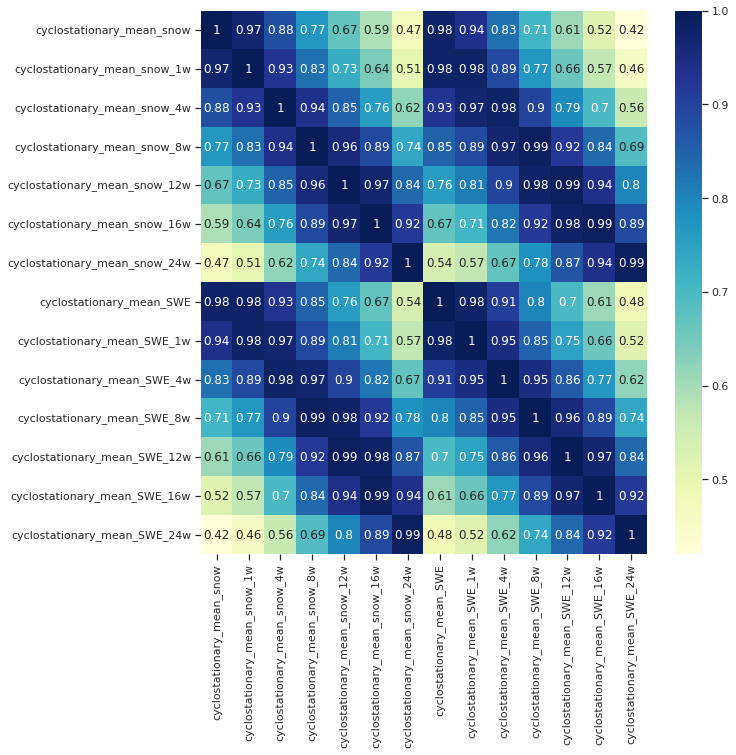

In [ ]:
cormat = features_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(round(cormat,2), annot=True, ax=ax, cmap="YlGnBu")

ax.set_facecolor('white')
sns.set_style('ticks')
# plt.savefig("correlation_matrix_features.jpg", bbox_inches = 'tight')